In [2]:
#Sentiment analysis from drug reviews
import pandas as pd
df = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB
None
   Unnamed: 0       urlDrugName  rating         effectiveness  \
0        2202         enalapril       4      Highly Effective   
1        3117  ortho-tri-cyclen       1      Highly Effective   
2        1146           ponstel      10      Highly Effective   
3        3947          prilosec       3  Marginally Effectiv

In [3]:

print(df.isnull().sum())
print(df['condition'].value_counts().head(10))

print(df['rating'].value_counts())

df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 7 else 0)
print(df['sentiment'].value_counts())


Unnamed: 0            0
urlDrugName           0
rating                0
effectiveness         0
sideEffects           0
condition             1
benefitsReview       18
sideEffectsReview    75
commentsReview       12
dtype: int64
condition
depression             236
acne                   165
anxiety                 63
insomnia                54
birth control           49
high blood pressure     42
allergies               37
acid reflux             33
asthma                  33
migraines               31
Name: count, dtype: int64
rating
10    742
8     558
9     480
7     350
1     305
5     159
6     157
3     146
4     107
2     103
Name: count, dtype: int64
sentiment
1    2130
0     977
Name: count, dtype: int64


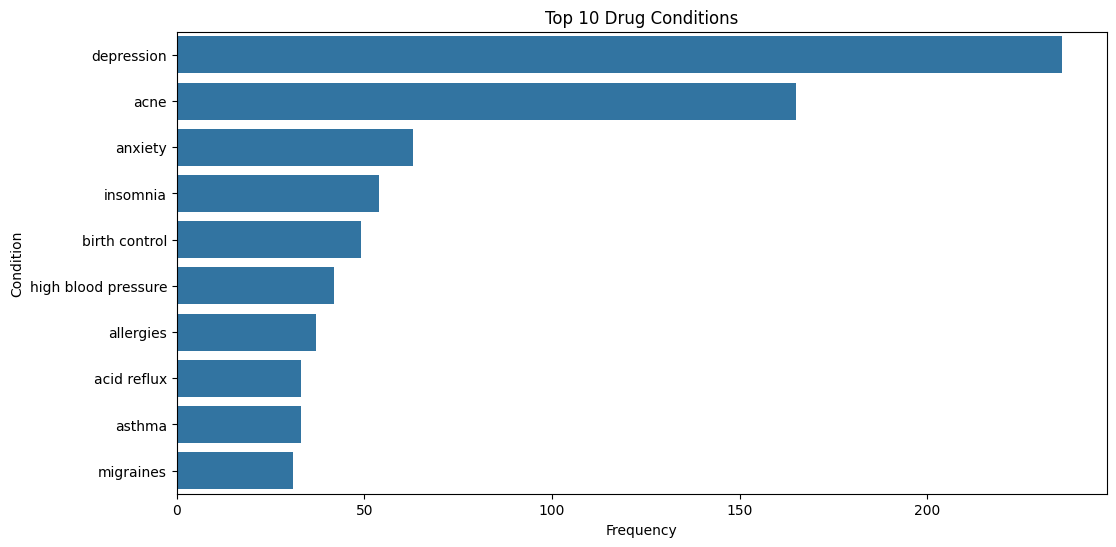

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
top_conditions = df['condition'].value_counts().head(10)
sns.barplot(x=top_conditions.values, y=top_conditions.index)
plt.title('Top 10 Drug Conditions')
plt.xlabel('Frequency')
plt.ylabel('Condition')
plt.show()


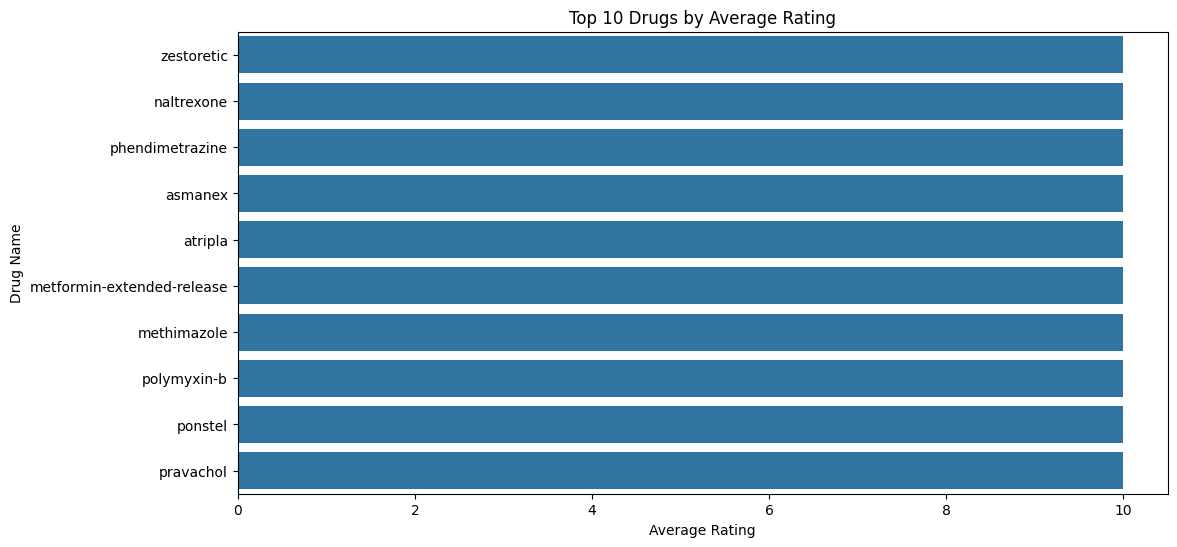

In [8]:
avg_rating = df.groupby('urlDrugName')['rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_rating.values, y=avg_rating.index)
plt.title('Top 10 Drugs by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Drug Name')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


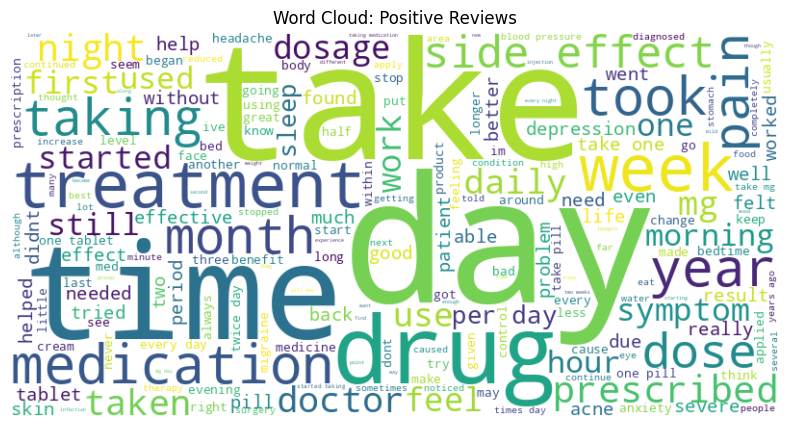

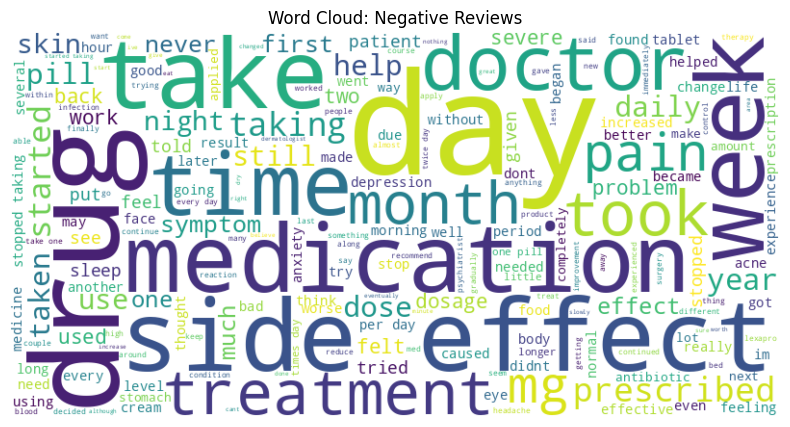

In [11]:
from wordcloud import WordCloud
import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_review'] = df['commentsReview'].apply(clean_text)

positive_reviews = df[df['sentiment'] == 1]['clean_review']
negative_reviews = df[df['sentiment'] == 0]['clean_review']


positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

wc_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Positive Reviews')
plt.show()


wc_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Negative Reviews')
plt.show()

In [12]:
#Question 2: Classification – Review Sentiment Prediction
import pandas as pd

df = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')

df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 7 else 0)

print(df['sentiment'].value_counts())


sentiment
1    2130
0     977
Name: count, dtype: int64


In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_review'] = df['commentsReview'].apply(preprocess_text)

print(df[['commentsReview', 'clean_review']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                      commentsReview  \
0  monitor blood pressure , weight and asses for ...   
1  I Hate This Birth Control, I Would Not Suggest...   
2  I took 2 pills at the onset of my menstrual cr...   
3  I was given Prilosec prescription at a dose of...   
4                                          See above   

                                        clean_review  
0  monitor blood pressure weight ass resolution f...  
1            hate birth control would suggest anyone  
2  took 2 pill onset menstrual cramp every 812 ho...  
3  given prilosec prescription dose 45mg per day ...  
4                                                see  


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_review']).toarray()
y = df['sentiment']


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.72      0.15      0.25       184
           1       0.73      0.97      0.84       438

    accuracy                           0.73       622
   macro avg       0.73      0.56      0.54       622
weighted avg       0.73      0.73      0.66       622

Random Forest Results:
              precision    recall  f1-score   support

           0       0.62      0.16      0.25       184
           1       0.73      0.96      0.83       438

    accuracy                           0.72       622
   macro avg       0.67      0.56      0.54       622
weighted avg       0.70      0.72      0.66       622



In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

# Evaluate tuned model
y_pred_best = grid.predict(X_test)
print("Tuned Random Forest Results:")
print(classification_report(y_test, y_pred_best))


Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Random Forest Results:
              precision    recall  f1-score   support

           0       0.67      0.17      0.28       184
           1       0.74      0.96      0.83       438

    accuracy                           0.73       622
   macro avg       0.70      0.57      0.55       622
weighted avg       0.71      0.73      0.67       622



In [19]:
import joblib

# Save final model
joblib.dump(grid.best_estimator_, 'rf_sentiment_model.pkl')

# Save TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!
